# Import libraries

In [1]:
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import time
import cv2
import pickle
import mediapipe as mp
import tensorflow as tf

from tqdm import tqdm
from collections import Counter
from matplotlib import pyplot as plt
from tensorflow.data import AUTOTUNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

2022-04-12 11:47:26.543569: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
ROUND = 2
EXERCISE = 'half-burpee'
CUR_CLASS = 'out'
PREV_CLASS = 'in'
SUBFIX_VID_NAME = '_hard_vote_r2'
REMOTE = True

# Define mediapipe functions

In [3]:
mp_pose = mp.solutions.pose
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [4]:
# def mediapipe_detection(image, model):
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     image.flags.writeable = False
#     results = model.process(image)
#     image.flags.writeable = True
#     image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
#     return image, results

In [5]:
# def draw_landmarks(image, results):
#     mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS)
#     mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
#     mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
#     mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

In [6]:
# def draw_styled_landmarks(image, results):
#     mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS,
#                               mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), # color for landmarks (dot)
#                               mp_drawing.DrawingSpec(color=(80,250,121), thickness=1, circle_radius=1)) # color for connection (line)
#     mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
#                               mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), # color for landmarks (dot)
#                               mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)) # color for connection (line)
#     mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
#                               mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), # color for landmarks (dot)
#                               mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)) # color for connection (line)
#     mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
#                               mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), # color for landmarks (dot)
#                               mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)) # color for connection (line)

# Load all file paths

In [7]:
SEQ_LEN = 8
all_file_paths = []
if REMOTE:
    walk_path = f'/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_{SEQ_LEN}/{EXERCISE}'
else:
    walk_path = f'D:\EzFit_dataset\keypoints_seq\len_{SEQ_LEN}\{EXERCISE}'
for path, subdirs, files in os.walk(walk_path):
    for name in files:
        if name.endswith('.npy'):
            full_path = os.path.join(path, name)
            if 'idle' not in full_path:
                all_file_paths.append(full_path)

In [8]:
all_file_paths

['/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/half-burpee/others/1057/others_1057.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/half-burpee/others/809/others_809.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/half-burpee/others/1025/others_1025.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/half-burpee/others/937/others_937.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/half-burpee/others/517/others_517.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/half-burpee/others/240/others_240.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/half-burpee/others/1443/others_1443.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/half-burpee/others/760/others_760.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/half-burpee/others/143/others_143.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/half

In [9]:
len(all_file_paths)

5300

In [10]:
# use for stratify and check balance
labels = list(map(lambda x: x.split(os.path.sep)[-3], all_file_paths))
labels

['others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',

In [11]:
# check balanceness
total = len(labels)
label_count = Counter(labels)
label_count, total

(Counter({'others': 1500, 'half-burpee-in': 1491, 'half-burpee-out': 2309}),
 5300)

In [12]:
def load_numpy(path):
    return np.load(path.numpy())

In [13]:
def load_data(file_path):
    # load numpy, file_path is Tensor with dtype string
    # and np.load not working with Tensor, so we need to work around with pure tf ops
    # this function return a list with elements following Tout, 
    # so we need to access first item
    data = tf.py_function(load_numpy, inp=[file_path], Tout=[tf.float32])[0] # return as tensor with dtype tf.float32
    data = tf.reshape(data, (99*SEQ_LEN,))
    
    # get label
    label_str = tf.strings.split(file_path, os.path.sep)[-3]
    one_hot = label_str == le.classes_ # get tensor with dtype bool
    label = tf.cast(one_hot, tf.int32)
    return data, label

# Preprocess

In [14]:
le = LabelEncoder()
le.fit(labels)
le.classes_

array(['half-burpee-in', 'half-burpee-out', 'others'], dtype='<U15')

In [15]:
labels = le.transform(labels)
labels

array([2, 2, 2, ..., 1, 1, 1])

In [16]:
train_paths, test_paths = train_test_split(all_file_paths, test_size=0.1, random_state=42, stratify=labels)

In [17]:
len(train_paths), len(test_paths)

(4770, 530)

# Class weighting
Since we have a bit imbalanced data, so we should do class weighting  
formula derived from here: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#calculate_class_weights

In [18]:
NUM_CLASSES = len(le.classes_)
class_weights = {}
for label in label_count:
    class_weights[le.transform([label])[0]] = (1 / label_count[label]) * (total / NUM_CLASSES)

In [19]:
class_weights

{2: 1.1777777777777778, 0: 1.184887100380058, 1: 0.7651219864299119}

# Build data pipeline

In [20]:
# define hyperparameters
EPOCHS = 150
BATCH_SIZE = 32
NUM_CLASSES = len(le.classes_)
INIT_LR = 1e-3

In [21]:
train_ds = tf.data.Dataset.from_tensor_slices(train_paths)
train_ds = (train_ds
            .shuffle(len(train_paths), seed=42)
            .map(load_data, num_parallel_calls=AUTOTUNE)
            .cache()
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE)
           )

2022-04-12 11:47:27.710770: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-04-12 11:47:27.758792: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 11:47:27.759330: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:09:00.0 name: GeForce RTX 2080 SUPER computeCapability: 7.5
coreClock: 1.845GHz coreCount: 48 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 462.00GiB/s
2022-04-12 11:47:27.759349: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-04-12 11:47:27.760851: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-04-12 11:47:27.760878: I tensorflow/stream_executor/plat

In [22]:
test_ds = tf.data.Dataset.from_tensor_slices(test_paths)
test_ds = (test_ds
            .map(load_data, num_parallel_calls=AUTOTUNE)
            .cache()
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE)
           )

In [23]:
# check the shape and dtype
next(iter(train_ds))

2022-04-12 11:47:28.281475: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-12 11:47:28.282307: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3499880000 Hz
2022-04-12 11:47:28.346792: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(<tf.Tensor: shape=(32, 792), dtype=float32, numpy=
 array([[0.20185654, 0.73411036, 0.9983353 , ..., 0.42195576, 0.86192423,
         0.6016353 ],
        [0.8512931 , 0.70000285, 0.9999322 , ..., 0.12778509, 0.79255617,
         0.94809693],
        [0.40102363, 0.35019764, 0.99814737, ..., 0.42609006, 0.70541596,
         0.88241655],
        ...,
        [0.4295813 , 0.56242067, 0.9975212 , ..., 0.7740547 , 0.7960058 ,
         0.6778163 ],
        [0.41953763, 0.5853263 , 0.9964336 , ..., 0.62584394, 0.6156477 ,
         0.7354182 ],
        [0.5866782 , 0.6604012 , 0.9997739 , ..., 0.31757537, 0.77984226,
         0.9794088 ]], dtype=float32)>,
 <tf.Tensor: shape=(32, 3), dtype=int32, numpy=
 array([[1, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
        [1, 0, 0],
        [1, 0, 0],
        [0, 0, 1],
        [1, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        

# Model training

In [24]:
# define callback (tensorboard)
log_dir = os.path.join('Logs')
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

2022-04-12 11:47:28.366422: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-04-12 11:47:28.366451: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-04-12 11:47:28.366486: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1611] Profiler found 1 GPUs
2022-04-12 11:47:28.366820: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda/extras/CUPTI/lib64
2022-04-12 11:47:28.367282: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcupti.so
2022-04-12 11:47:28.446626: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-04-12 11:47:28.446727: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed


In [25]:
# build model
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(99*SEQ_LEN,), dtype=tf.dtypes.float32),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               203008    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 9

In [27]:
optimizer = tf.keras.optimizers.Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)

In [28]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
model.fit(train_ds, 
          validation_data=test_ds, 
          epochs=EPOCHS, 
          callbacks=[early_stopping, tb_callback],
          class_weight=class_weights)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/150


2022-04-12 11:47:29.034850: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


  2/150 [..............................] - ETA: 29s - loss: 1.2715 - accuracy: 0.3125 

2022-04-12 11:47:29.336742: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-04-12 11:47:29.381743: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-04-12 11:47:29.381767: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


  7/150 [>.............................] - ETA: 10s - loss: 1.1555 - accuracy: 0.3259

2022-04-12 11:47:29.592242: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-12 11:47:29.593061: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed
2022-04-12 11:47:29.623433: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 121 callback api events and 118 activity events. 
2022-04-12 11:47:29.632927: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-04-12 11:47:29.662923: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/profile/2022_04_12_11_47_29
2022-04-12 11:47:29.685847: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to Logs/train/plugins/profile/2022_04_12_11_47_29/jarvis.trace.json.gz
2022-04-12 11:47:29.698199: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/pro

150/150 [==============================] - 4s 21ms/step - loss: 0.8640 - accuracy: 0.5331 - val_loss: 0.8150 - val_accuracy: 0.6208
Epoch 2/150
150/150 [==============================] - 0s 2ms/step - loss: 0.7790 - accuracy: 0.5824 - val_loss: 0.7293 - val_accuracy: 0.5113
Epoch 3/150
150/150 [==============================] - 0s 2ms/step - loss: 0.6965 - accuracy: 0.6170 - val_loss: 0.6177 - val_accuracy: 0.6528
Epoch 4/150
150/150 [==============================] - 0s 2ms/step - loss: 0.6610 - accuracy: 0.6403 - val_loss: 0.5831 - val_accuracy: 0.6981
Epoch 5/150
150/150 [==============================] - 0s 2ms/step - loss: 0.6120 - accuracy: 0.6751 - val_loss: 0.6801 - val_accuracy: 0.5491
Epoch 6/150
150/150 [==============================] - 0s 2ms/step - loss: 0.5911 - accuracy: 0.6799 - val_loss: 0.4952 - val_accuracy: 0.7698
Epoch 7/150
150/150 [==============================] - 0s 2ms/step - loss: 0.5268 - accuracy: 0.7241 - val_loss: 0.5776 - val_accuracy: 0.7264
Epoch 8/15

# Setup all dirs
*Note:* You have to create visualization dir at the bottom most manually

In [30]:
import os

In [31]:
all_dirs = []
model_dir = f'saved_models/round_{ROUND}/{EXERCISE}/'
all_dirs.append(model_dir)
pickle_dir = f'saved_pickles/round_{ROUND}/{EXERCISE}/'
all_dirs.append(pickle_dir)
output_vid_dir = f'output_videos/round_{ROUND}/{EXERCISE}/'
all_dirs.append(output_vid_dir)

In [32]:
for d in all_dirs:
    if not os.path.exists(d):
        os.makedirs(d, exist_ok=True)

# Save model

In [33]:
model.save(os.path.join(model_dir, f'{EXERCISE}_kps_stacked.h5'), save_format='h5')

In [34]:
# serialize lb
with open(os.path.join(pickle_dir, f'{EXERCISE}_kps_stacked_le.pickle'), 'wb') as file:
    pickle.dump(le, file)

In [35]:
# command to run tensorboard
# first, going logs directory then,
# tensorboard --logdir=.

# Evaluate the model

In [36]:
raw_preds_y = model.predict(test_ds)
preds_y = np.argmax(raw_preds_y, axis=1)
preds_y

array([1, 2, 1, 0, 2, 1, 1, 0, 0, 1, 2, 1, 1, 1, 2, 0, 1, 0, 0, 2, 2, 2,
       2, 1, 0, 1, 1, 1, 1, 1, 0, 2, 2, 2, 0, 1, 0, 1, 0, 1, 1, 2, 0, 1,
       1, 1, 2, 0, 1, 2, 2, 1, 1, 0, 0, 0, 1, 0, 0, 2, 1, 2, 1, 2, 1, 1,
       1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 0, 1, 2, 0, 1, 0, 1, 2, 2, 0, 1, 2,
       0, 2, 2, 2, 1, 2, 0, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 2, 0, 1, 1, 0, 0, 2, 2, 2, 2,
       1, 2, 1, 2, 1, 1, 0, 1, 2, 1, 2, 1, 0, 2, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 2, 1, 1, 2, 1, 1, 1, 1, 0, 2, 0, 0, 1, 0, 1, 1, 1, 1, 0, 2, 1,
       1, 1, 1, 0, 2, 1, 0, 2, 0, 2, 0, 2, 0, 0, 1, 2, 0, 1, 2, 1, 1, 1,
       2, 2, 2, 2, 1, 2, 1, 1, 0, 2, 2, 1, 1, 1, 0, 1, 1, 2, 2, 2, 1, 0,
       2, 2, 0, 1, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 2, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 2, 2, 1, 0, 2, 1, 0, 1, 2, 2, 2, 2, 2, 2, 1, 1, 0,
       0, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 2, 1, 2, 2,

In [37]:
# get y label back from tf.data
raw_test_y = np.concatenate([y for x, y in test_ds], axis=0)
test_y = np.argmax(raw_test_y, axis=1)
test_y

array([1, 2, 1, 0, 2, 1, 0, 0, 0, 1, 2, 1, 1, 1, 2, 0, 1, 0, 0, 2, 2, 2,
       2, 1, 0, 1, 1, 1, 1, 1, 0, 2, 2, 2, 0, 1, 0, 1, 0, 1, 1, 2, 0, 1,
       1, 1, 2, 0, 1, 2, 2, 1, 1, 0, 0, 0, 1, 0, 0, 2, 1, 2, 1, 2, 1, 1,
       1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 0, 1, 2, 0, 1, 0, 1, 2, 2, 0, 1, 2,
       0, 2, 2, 2, 1, 2, 0, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 2, 0, 1, 1, 0, 0, 2, 2, 2, 2,
       1, 2, 1, 2, 1, 1, 0, 1, 2, 1, 2, 1, 0, 2, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 2, 1, 1, 2, 1, 1, 1, 1, 0, 2, 0, 0, 1, 0, 1, 1, 1, 1, 0, 2, 1,
       1, 1, 1, 0, 2, 1, 0, 2, 0, 2, 0, 2, 0, 0, 1, 2, 0, 1, 2, 1, 1, 1,
       2, 2, 2, 2, 1, 2, 1, 1, 0, 2, 2, 1, 1, 1, 0, 1, 1, 2, 2, 2, 1, 0,
       2, 2, 0, 1, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 2, 0, 1, 0, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 2,
       0, 0, 1, 1, 0, 2, 2, 1, 0, 2, 1, 0, 1, 2, 2, 2, 2, 2, 2, 1, 1, 0,
       0, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 2, 1, 2, 2,

In [38]:
test_y_text = le.inverse_transform(test_y)
preds_y_text = le.inverse_transform(preds_y)

### Accuracy

In [39]:
_, acc = model.evaluate(test_ds)
print('Test accuracy:', acc)

17/17 [==============================] - 0s 1ms/step - loss: 0.0454 - accuracy: 0.9868
Test accuracy: 0.9867924451828003


### Confusion Matrix

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [41]:
cm = confusion_matrix(test_y_text, preds_y_text, labels=le.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=le.classes_)

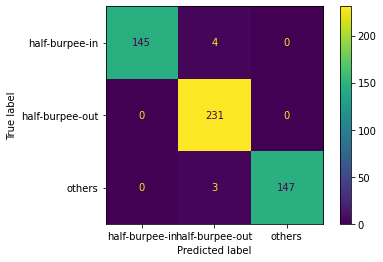

In [42]:
disp.plot()
plt.savefig(f'saved_artifacts/conf_matrix/final/{EXERCISE}/kps_stacked_cm_r2.png', dpi=300)
plt.show()

Investigate data | Too short seq len?

### ROC AUC

In [43]:
from sklearn.metrics import roc_auc_score

In [44]:
roc_auc_score(raw_test_y, raw_preds_y)

0.9994871913783049

# Detect in realtime

In [45]:
loaded_model = tf.keras.models.load_model(os.path.join(model_dir, f'{EXERCISE}_kps_stacked.h5'))

In [46]:
loaded_model.inputs

[<KerasTensor: shape=(None, 792) dtype=float32 (created by layer 'input_1')>]

In [47]:
loaded_model.outputs

[<KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'dense_5')>]

In [48]:
# serialize model and le
with open(os.path.join(pickle_dir, f'{EXERCISE}_kps_stacked_le.pickle'), 'rb') as file:
    loaded_le = pickle.load(file)

In [49]:
from collections import deque, Counter

In [50]:
NUM_TEST_VIDS = 3
SEQ_LEN = 8
exercise = EXERCISE
for i in range(1,1+NUM_TEST_VIDS):
    kps_seq = deque(maxlen=SEQ_LEN)
    preds_window = deque(maxlen=15)
    rep_count = 0
    current_stage = None
    previous_stage = None
    cap = cv2.VideoCapture(f'objective_test_videos/{EXERCISE}/{EXERCISE}_{i}.mp4')
    # video_width = int(cap.get(3))
    # video_height = int(cap.get(4))
    # video_size = (video_width, video_height)
    video_size = (640, 360)
    video_writer = cv2.VideoWriter(os.path.join(output_vid_dir, f'{EXERCISE}_{i}_kps_stacked{SUBFIX_VID_NAME}.avi'), cv2.VideoWriter_fourcc(*'MJPG'),
                                   25, video_size)

    with mp_pose.Pose(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as pose:
        while cap.isOpened():
            success, frame = cap.read()
            if not success:
                break

            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            image = cv2.resize(image, (640, 360))

            image.flags.writeable = False

            results = pose.process(image)

            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            # Pose Detections
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, 
                                     mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                     mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                     )

            # append face&body coordinates for each frame to the csv file to create dataset to train the model
            try:
                # extract pose
                pose_coor = results.pose_landmarks.landmark
                pose_row = np.array([[landmark.x, landmark.y, landmark.visibility] for landmark in pose_coor]).flatten()
                # append new coor to the sequence array
                kps_seq.append(pose_row)

                if len(kps_seq) == SEQ_LEN:
                    seq_arr = np.array(kps_seq).flatten()
                    y_hat = loaded_model.predict(tf.expand_dims(seq_arr, axis=0))[0]
                    y_idx = np.argmax(y_hat)
                    
                    if 'hard_vote' in SUBFIX_VID_NAME:
                        # do hard voting
                        preds_window.append(y_idx)
                        pred_count = Counter(preds_window)
                        # most_common return .items() format
                        # ex. [(0,5), (1,3)]
                        voted_pred = pred_count.most_common(1)[0][0]
                        class_name = loaded_le.classes_[voted_pred]
                    else:
                        class_name = loaded_le.classes_[y_idx]
                        
                    prob = np.max(y_hat)
                    print(y_hat, class_name, prob, end='\r')
                else:
                    class_name = "None"
                    prob = 0

                # count the rep logic
                current_stage = class_name

                if current_stage == f'{EXERCISE}-{CUR_CLASS}' and previous_stage == f'{EXERCISE}-{PREV_CLASS}':
                    rep_count += 1

                previous_stage = current_stage

                print('rep:',rep_count, end='\r')

    #             image = cv2.resize(image, (640, 368))

                # status box at top left corner
                cv2.rectangle(image, (0,0), (320,60), (245,117,16), -1)

                # display class
                cv2.putText(image, 'Class', (95, 12),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
                cv2.putText(image, class_name, (95, 40),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

                # display prob
                cv2.putText(image, 'Prob', (15, 12),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
                cv2.putText(image, str(round(np.max(prob),2)), (10, 40),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

                # rep count box at top right corner
                cv2.rectangle(image, (580, 60), (640, 0), (245,117,16), -1)

                # display rep count
                cv2.putText(image, 'Rep', (640-52, 0+15),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
                cv2.putText(image, str(rep_count), (640-52, 0+50),
                            cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255,255,255), 2, cv2.LINE_AA)

            except Exception as e:
                print('[INFO] error:', e)

            video_writer.write(image)
            if not REMOTE:
                cv2.imshow(f'{EXERCISE} Count Detection', image)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

        cap.release()
        video_writer.release()
        if not REMOTE:
            cv2.destroyAllWindows()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
INFO: Replacing 223 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 6 partitions.
INFO: Replacing 318 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 1 partitions.


INFO: Replacing 223 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 6 partitions.
INFO: Replacing 318 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 1 partitions.


[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'76
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no

INFO: Replacing 223 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 6 partitions.
INFO: Replacing 318 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 1 partitions.


[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'36034
[INFO] error: 'NoneType' object has

# Save class for visualization
only best performing model

In [51]:
NUM_TEST_VIDS = 3
SEQ_LEN = 8
exercise = EXERCISE
for i in range(1, 1+NUM_TEST_VIDS):
    predicted_class = []
    kps_seq = deque(maxlen=SEQ_LEN)
    preds_window = deque(maxlen=15)
    cap = cv2.VideoCapture(f'objective_test_videos/{EXERCISE}/{EXERCISE}_{i}.mp4')
    total_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # video_width = int(cap.get(3))
    # video_height = int(cap.get(4))
    # video_size = (video_width, video_height)
    video_size = (640, 360)

    with mp_pose.Pose(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as pose:
        while cap.isOpened():
            success, frame = cap.read()
            if not success:
                break

            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            image = cv2.resize(image, (640, 360))

            image.flags.writeable = False

            results = pose.process(image)

            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            # Pose Detections
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, 
                                     mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                     mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                     )

            # append face&body coordinates for each frame to the csv file to create dataset to train the model
            try:
                # extract pose
                pose_coor = results.pose_landmarks.landmark
                pose_row = np.array([[landmark.x, landmark.y, landmark.visibility] for landmark in pose_coor]).flatten()
                # append new coor to the sequence array
                kps_seq.append(pose_row)
                
                if len(kps_seq) == SEQ_LEN:
                    seq_arr = np.array(kps_seq).flatten()
                    y_hat = loaded_model.predict(tf.expand_dims(seq_arr, axis=0))[0]
                    y_idx = np.argmax(y_hat)
                    
                    if 'hard_vote' in SUBFIX_VID_NAME:
                        # do hard voting
                        preds_window.append(y_idx)
                        pred_count = Counter(preds_window)
                        # most_common return .items() format
                        # ex. [(0,5), (1,3)]
                        voted_pred = pred_count.most_common(1)[0][0]
                        class_name = loaded_le.classes_[voted_pred]
                        predicted_class.append(voted_pred)
                    else:
                        class_name = loaded_le.classes_[y_idx]
                        predicted_class.append(y_idx)

                    prob = np.max(y_hat)
                    print(y_hat, class_name, prob, end='\r')
                else:
                    predicted_class.append(0)
                    class_name = "None"
                    prob = 0

                    
                # status box at top left corner
                cv2.rectangle(image, (0,0), (320,60), (245,117,16), -1)

                # display class
                cv2.putText(image, 'Class', (95, 12),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
                cv2.putText(image, class_name, (95, 40),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

                # display prob
                cv2.putText(image, 'Prob', (15, 12),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
                cv2.putText(image, str(round(np.max(prob),2)), (10, 40),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

                # rep count box at top right corner
                cv2.rectangle(image, (580, 60), (640, 0), (245,117,16), -1)

            except Exception as e:
                predicted_class.append(0)
                print('[INFO] error:', e)
                
            if not REMOTE:
                cv2.imshow(f'{EXERCISE} Count Detection', image)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

        assert len(predicted_class) == total_frame, f"# of label {len(predicted_class)} != # of frames in the video {total_frame}"
        
        temp_save_path = f'saved_pickles/for_visualization/{EXERCISE}/test_vid_{i}/round_{ROUND}'
        if not os.path.exists(temp_save_path):
            os.makedirs(temp_save_path, exist_ok=True)
        with open(os.path.join(temp_save_path, f'test_vid_{i}_kps_stacked{SUBFIX_VID_NAME}.pickle'), 'wb') as f:
            pickle.dump(predicted_class, f)
        cap.release()
        if not REMOTE:
            cv2.destroyAllWindows()

INFO: Replacing 223 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 6 partitions.
INFO: Replacing 318 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 1 partitions.


INFO: Replacing 223 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 6 partitions.
INFO: Replacing 318 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 1 partitions.


[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'76
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no

INFO: Replacing 223 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 6 partitions.
INFO: Replacing 318 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 1 partitions.


[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'36034
[INFO] error: 'NoneType' object has